Filter for selected companies and sort

In [16]:
import pandas as pd

# Load and filter for selected companies
selected_companies = ['AAPL', 'GOOGL', 'NVDA', 'AMZN']
df = pd.read_csv('/content/stock_details_5_years.csv')
df = df[df['Company'].isin(selected_companies)].copy()

# Convert Date to datetime and sort
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by=['Company', 'Date'], inplace=True)

<ipython-input-16-725823b4c1f6>:9: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['Date'] = pd.to_datetime(df['Date'])


In [19]:
def compute_indicators(group):
    group['Return'] = group['Close'].pct_change()
    group['SMA_20'] = group['Close'].rolling(window=20).mean()
    group['EMA_20'] = group['Close'].ewm(span=20, adjust=False).mean()
    group['Volatility_20'] = group['Return'].rolling(window=20).std()

    # MACD & Signal Line
    ema_12 = group['Close'].ewm(span=12, adjust=False).mean()
    ema_26 = group['Close'].ewm(span=26, adjust=False).mean()
    group['MACD'] = ema_12 - ema_26
    group['Signal'] = group['MACD'].ewm(span=9, adjust=False).mean()

    # RSI
    delta = group['Close'].diff()
    gain = delta.clip(lower=0).rolling(window=14).mean()
    loss = -delta.clip(upper=0).rolling(window=14).mean()
    rs = gain / loss
    group['RSI'] = 100 - (100 / (1 + rs))

    return group

df = df.groupby('Company').apply(compute_indicators).reset_index(drop=True)


<ipython-input-19-10bdadbf9669>:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Company').apply(compute_indicators).reset_index(drop=True)


In [20]:
from sklearn.preprocessing import StandardScaler

# Define features and drop missing rows
features = ['Close', 'Return', 'Volatility_20', 'RSI', 'MACD']
df_clean = df.dropna(subset=features).copy()

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean[features])


In [21]:
from sklearn.ensemble import IsolationForest

# Initialize and fit Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)
df_clean['anomaly_score'] = iso_forest.fit_predict(X_scaled)


In [22]:
# Mark anomalies (where score is -1)
df_clean['is_anomaly'] = df_clean['anomaly_score'] == -1

# Preview a few anomalies
df_clean[df_clean['is_anomaly']].head()


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Company,Return,SMA_20,EMA_20,Volatility_20,MACD,Signal,RSI,anomaly_score,is_anomaly
4099,2020-03-18 00:00:00-04:00,49.864479,52.316584,45.025055,50.542297,87426800,0.0,0.0,NVDA,-0.066507,63.799232,61.087241,0.076252,-3.312328,-1.326881,40.306137,-1,True
4103,2020-03-24 00:00:00-04:00,57.066284,62.962304,56.829547,62.095093,110164400,0.0,0.0,NVDA,0.171564,60.599163,59.155962,0.086601,-3.033080,-2.596968,43.323126,-1,True
4112,2020-04-06 00:00:00-04:00,63.605227,67.253482,63.029577,66.884666,72788400,0.0,0.0,NVDA,0.100406,59.276794,61.827483,0.087022,0.368099,-0.601102,64.300508,-1,True
4512,2021-11-04 00:00:00-04:00,271.905576,313.207167,270.797127,297.589264,115363100,0.0,0.0,NVDA,0.120422,234.791054,242.894604,0.030505,15.910783,9.887270,94.878477,-1,True
4514,2021-11-08 00:00:00-05:00,301.064362,310.560946,298.647795,307.605133,50310100,0.0,0.0,NVDA,0.035359,244.292621,253.728267,0.029708,20.611436,13.360992,94.725788,-1,True


In [23]:
# Install Prophet (if running in a new environment)
# !pip install prophet

from prophet import Prophet


In [24]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

# Load data
df = pd.read_csv('/content/stock_details_5_years.csv')

# Filter for selected companies
companies = ['AAPL', 'GOOGL', 'NVDA', 'AMZN']
df = df[df['Company'].isin(companies)].copy()

# Convert to datetime
df['Date'] = pd.to_datetime(df['Date'], utc=True)
df.sort_values(by=['Company', 'Date'], inplace=True)

# Compute indicators
def compute_indicators(group):
    group['Return'] = group['Close'].pct_change()
    group['Volatility_20'] = group['Return'].rolling(window=20).std()
    ema_12 = group['Close'].ewm(span=12).mean()
    ema_26 = group['Close'].ewm(span=26).mean()
    group['MACD'] = ema_12 - ema_26
    group['Signal'] = group['MACD'].ewm(span=9).mean()
    delta = group['Close'].diff()
    gain = delta.clip(lower=0).rolling(14).mean()
    loss = -delta.clip(upper=0).rolling(14).mean()
    rs = gain / loss
    group['RSI'] = 100 - (100 / (1 + rs))
    return group

df = df.groupby('Company').apply(compute_indicators).reset_index(drop=True)



<ipython-input-24-3696cac103fe>:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Company').apply(compute_indicators).reset_index(drop=True)


In [25]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

# Load data
df = pd.read_csv('/content/stock_details_5_years.csv')

# Filter for selected companies
companies = ['AAPL', 'GOOGL', 'NVDA', 'AMZN']
df = df[df['Company'].isin(companies)].copy()

# Convert to datetime
df['Date'] = pd.to_datetime(df['Date'], utc=True)
df.sort_values(by=['Company', 'Date'], inplace=True)

# Compute indicators
def compute_indicators(group):
    group['Return'] = group['Close'].pct_change()
    group['Volatility_20'] = group['Return'].rolling(window=20).std()
    ema_12 = group['Close'].ewm(span=12).mean()
    ema_26 = group['Close'].ewm(span=26).mean()
    group['MACD'] = ema_12 - ema_26
    group['Signal'] = group['MACD'].ewm(span=9).mean()
    delta = group['Close'].diff()
    gain = delta.clip(lower=0).rolling(14).mean()
    loss = -delta.clip(upper=0).rolling(14).mean()
    rs = gain / loss
    group['RSI'] = 100 - (100 / (1 + rs))
    return group

df = df.groupby('Company').apply(compute_indicators).reset_index(drop=True)


<ipython-input-25-06cdc431ae24>:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Company').apply(compute_indicators).reset_index(drop=True)


In [26]:
# Drop NA and scale features
features = ['Close', 'Return', 'Volatility_20', 'RSI', 'MACD']
df_clean = df.dropna(subset=features).copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean[features])

# Run Isolation Forest
iso = IsolationForest(contamination=0.01, random_state=42)
df_clean['anomaly_score'] = iso.fit_predict(X_scaled)
df_clean['is_anomaly'] = df_clean['anomaly_score'] == -1


In [27]:
from prophet import Prophet

# Prepare AAPL data
df_aapl = df_clean[df_clean['Company'] == 'AAPL'][['Date', 'Close', 'is_anomaly']].copy()
df_aapl['ds'] = pd.to_datetime(df_aapl['Date'], utc=True).dt.tz_localize(None)
df_aapl.rename(columns={'Close': 'y'}, inplace=True)
df_aapl.sort_values('ds', inplace=True)

# Fit Prophet model
model = Prophet(daily_seasonality=True)
model.fit(df_aapl[['ds', 'y']])

# Forecast
future = model.make_future_dataframe(periods=0)
forecast = model.predict(future)

# Merge with original
df_forecast = df_aapl.merge(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')
df_forecast['residual'] = df_forecast['y'] - df_forecast['yhat']


DEBUG:cmdstanpy:input tempfile: /tmp/tmppcvdvus_/bfqsko5a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppcvdvus_/6xhsx91q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96409', 'data', 'file=/tmp/tmppcvdvus_/bfqsko5a.json', 'init=/tmp/tmppcvdvus_/6xhsx91q.json', 'output', 'file=/tmp/tmppcvdvus_/prophet_model77qfd0rs/prophet_model-20250520121050.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:10:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:10:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Visualize with Anomalies

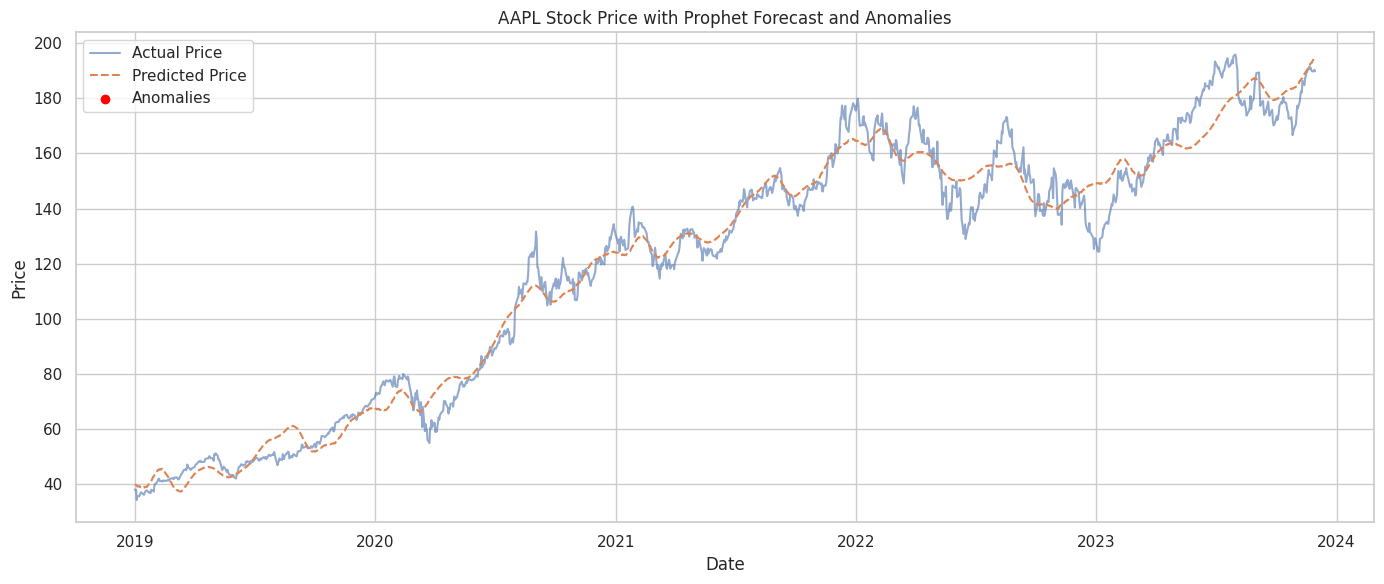

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(df_forecast['ds'], df_forecast['y'], label='Actual Price', alpha=0.6)
plt.plot(df_forecast['ds'], df_forecast['yhat'], label='Predicted Price', linestyle='--')

# Plot anomalies
anomalies = df_forecast[df_forecast['is_anomaly']]
plt.scatter(anomalies['ds'], anomalies['y'], color='red', label='Anomalies', zorder=5)

plt.title('AAPL Stock Price with Prophet Forecast and Anomalies')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [31]:
# Select columns to export
df_export = df_forecast[['ds', 'y', 'yhat', 'yhat_lower', 'yhat_upper', 'residual', 'is_anomaly']].copy()

# Rename for clarity
df_export.rename(columns={
    'ds': 'Date',
    'y': 'Actual_Close',
    'yhat': 'Predicted_Close',
    'yhat_lower': 'Predicted_Lower_Bound',
    'yhat_upper': 'Predicted_Upper_Bound',
    'residual': 'Residual',
    'is_anomaly': 'Anomaly_Flag'
}, inplace=True)

# Export to CSV
df_export.to_csv('/content/AAPL_anomaly_forecast.csv', index=False)

print("✅ AAPL anomaly forecast exported as 'AAPL_anomaly_forecast.csv'")


✅ AAPL anomaly forecast exported as 'AAPL_anomaly_forecast.csv'


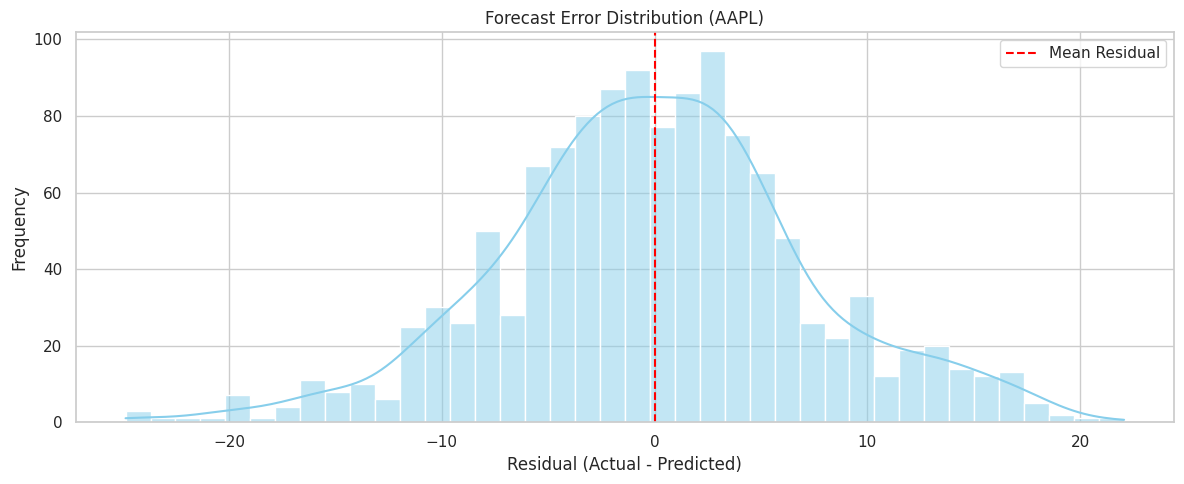

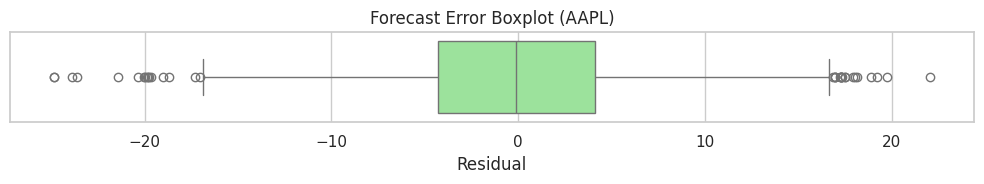

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style
sns.set(style='whitegrid')

# Histogram: Forecast error distribution
plt.figure(figsize=(12, 5))
sns.histplot(df_forecast['residual'], bins=40, kde=True, color='skyblue')
plt.axvline(df_forecast['residual'].mean(), color='red', linestyle='--', label='Mean Residual')
plt.title('Forecast Error Distribution (AAPL)')
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# Boxplot: Outliers in forecast errors
plt.figure(figsize=(10, 2))
sns.boxplot(x=df_forecast['residual'], color='lightgreen')
plt.title('Forecast Error Boxplot (AAPL)')
plt.xlabel('Residual')
plt.tight_layout()
plt.show()


DEBUG:cmdstanpy:input tempfile: /tmp/tmppcvdvus_/gfnq357s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppcvdvus_/o3v0baz_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54980', 'data', 'file=/tmp/tmppcvdvus_/gfnq357s.json', 'init=/tmp/tmppcvdvus_/o3v0baz_.json', 'output', 'file=/tmp/tmppcvdvus_/prophet_modelp43hvaed/prophet_model-20250520121957.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:19:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



📊 Forecasting and Anomaly Detection for GOOGL


12:19:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


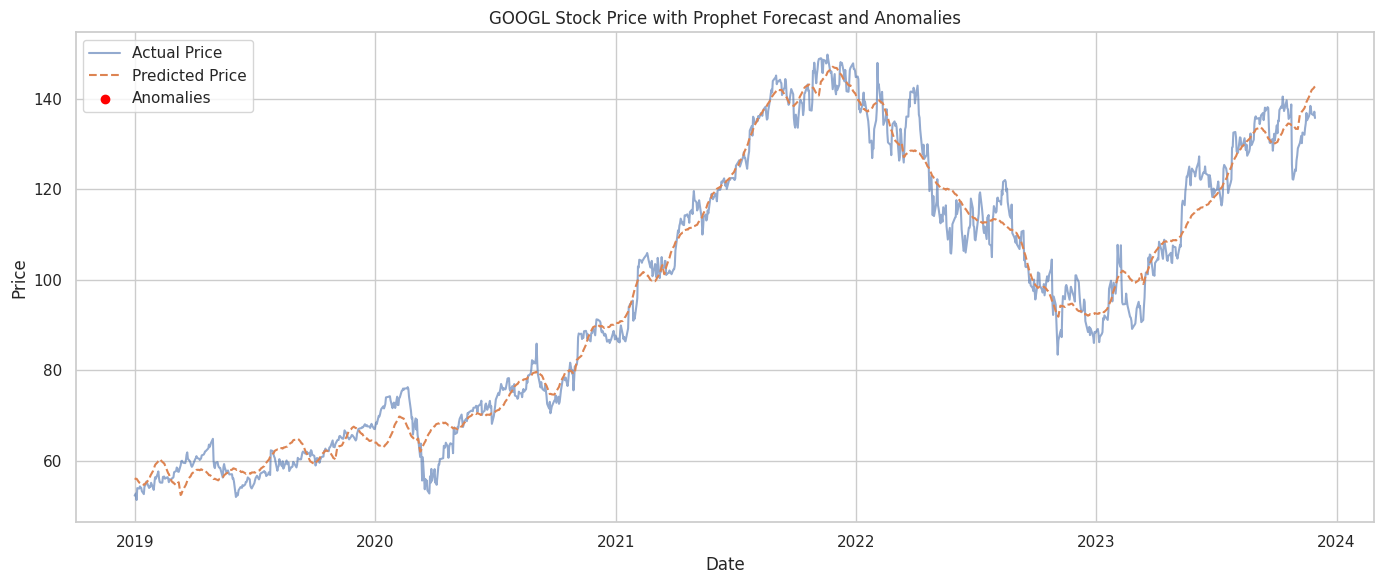

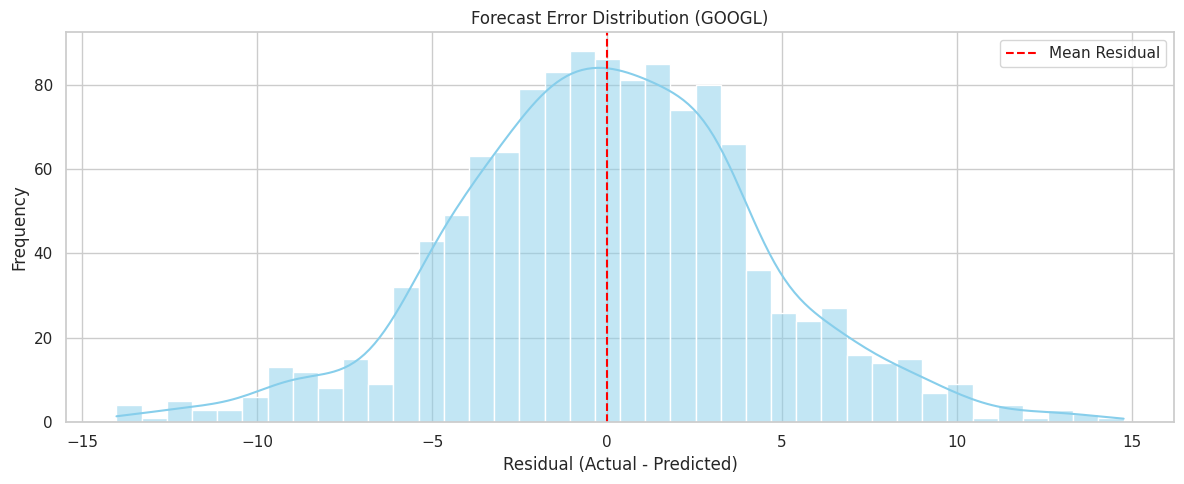

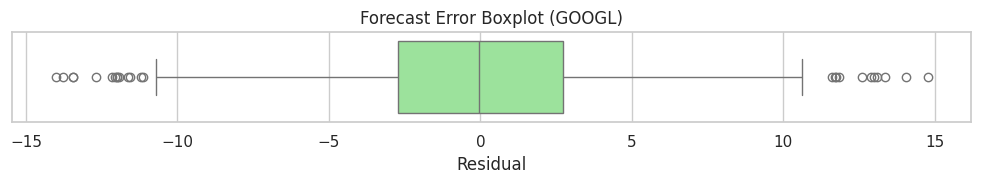

DEBUG:cmdstanpy:input tempfile: /tmp/tmppcvdvus_/hmmmx4jd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppcvdvus_/53eh27bn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24878', 'data', 'file=/tmp/tmppcvdvus_/hmmmx4jd.json', 'init=/tmp/tmppcvdvus_/53eh27bn.json', 'output', 'file=/tmp/tmppcvdvus_/prophet_modela7kuw2_l/prophet_model-20250520121958.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:19:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



📊 Forecasting and Anomaly Detection for NVDA


12:19:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


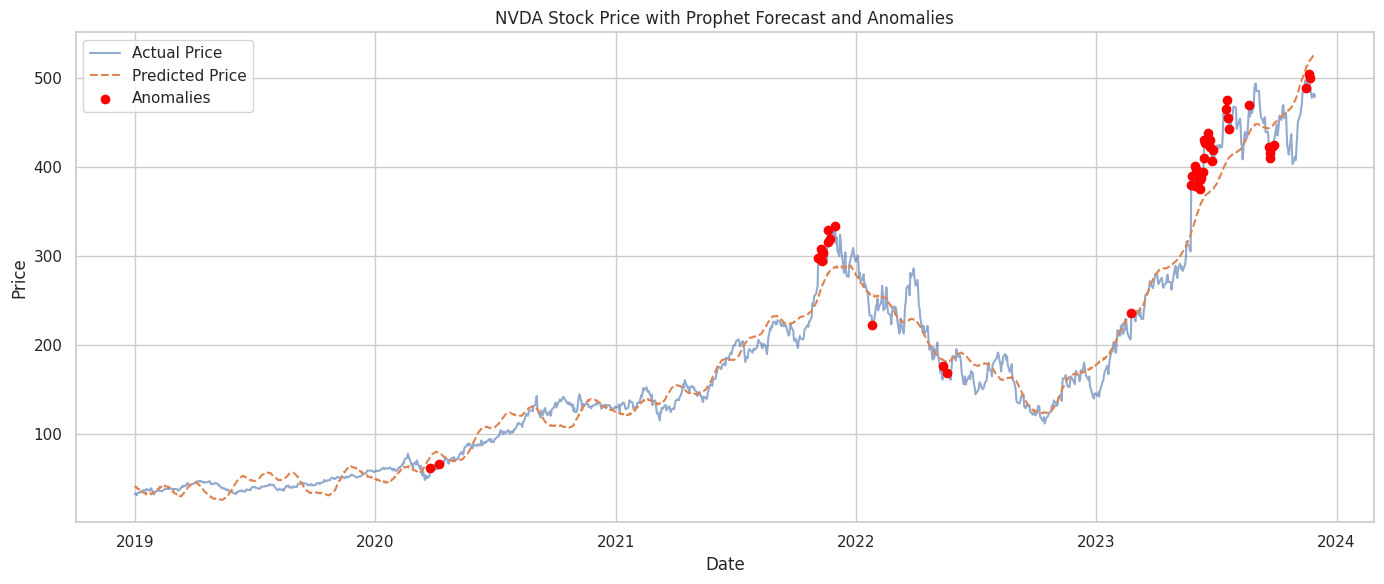

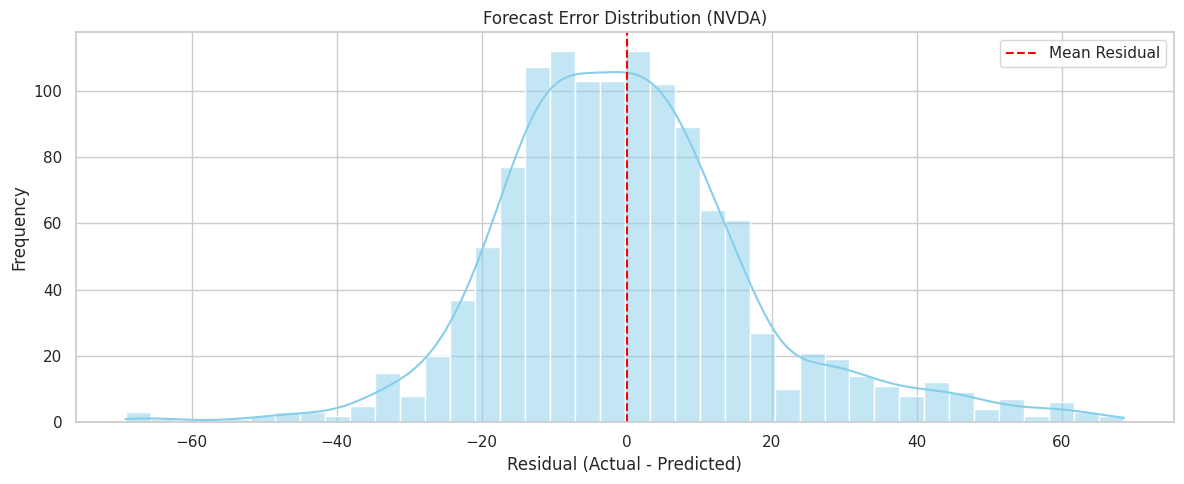

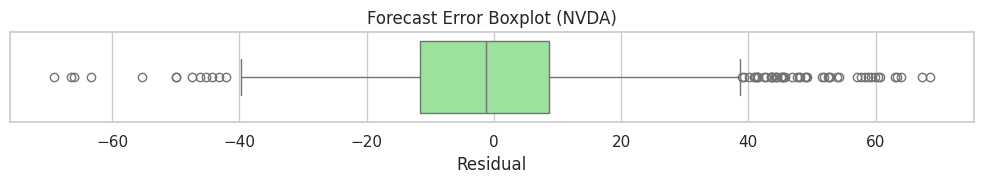

DEBUG:cmdstanpy:input tempfile: /tmp/tmppcvdvus_/offbfdv6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppcvdvus_/e4wpxxeq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95456', 'data', 'file=/tmp/tmppcvdvus_/offbfdv6.json', 'init=/tmp/tmppcvdvus_/e4wpxxeq.json', 'output', 'file=/tmp/tmppcvdvus_/prophet_model0b_r745k/prophet_model-20250520122000.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:20:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



📊 Forecasting and Anomaly Detection for AMZN


12:20:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


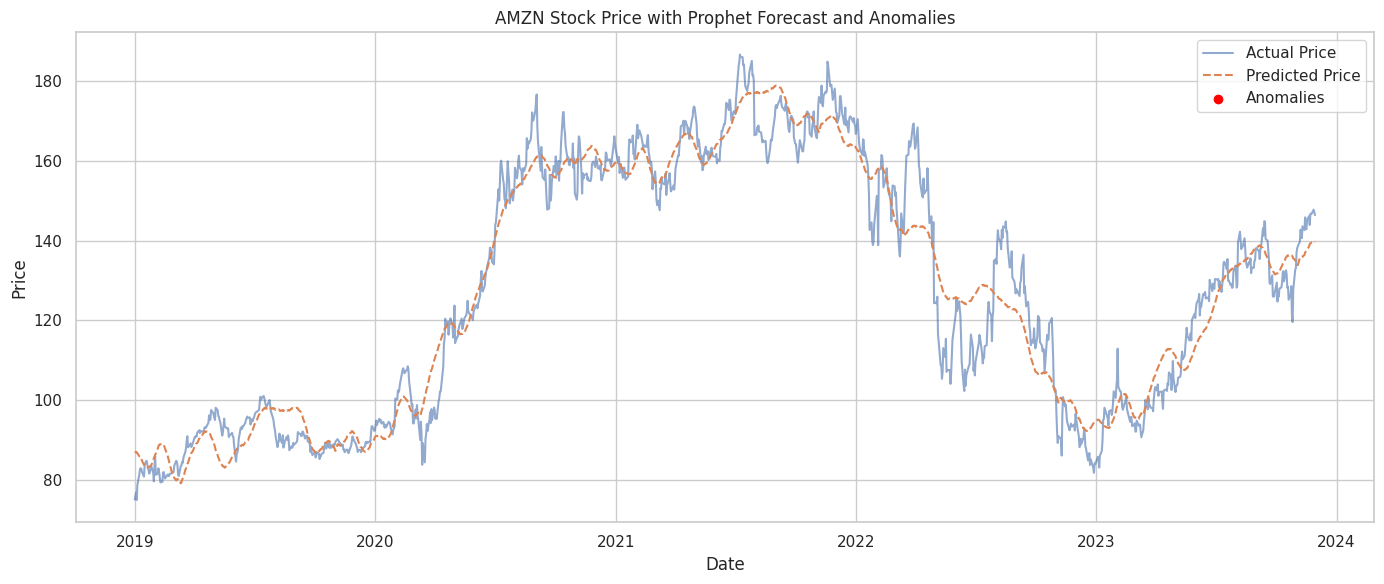

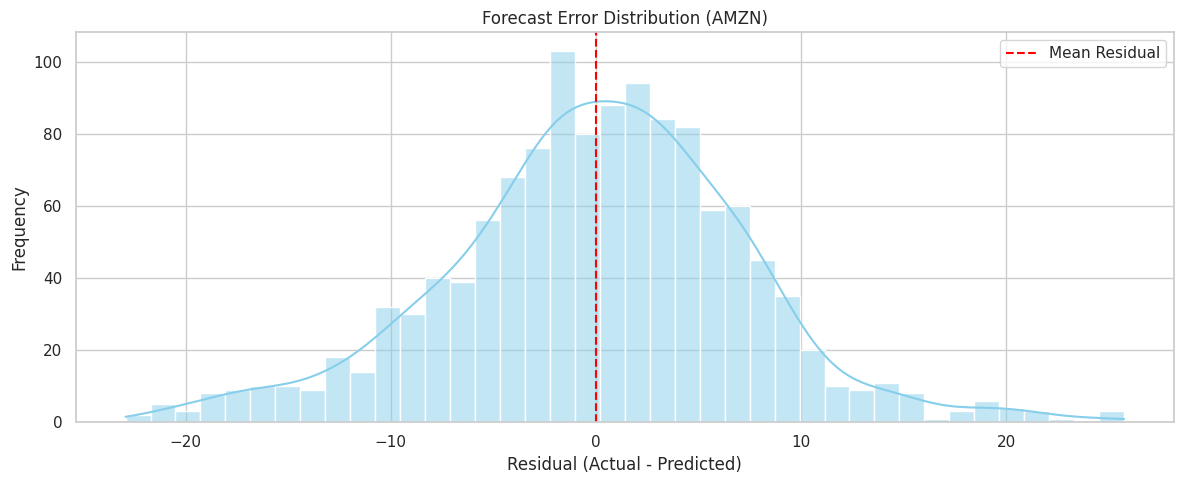

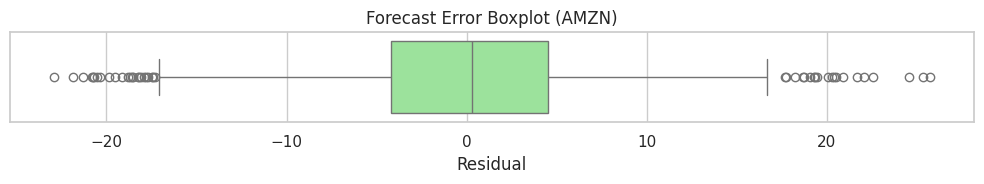

In [34]:
from prophet import Prophet
import seaborn as sns
import matplotlib.pyplot as plt

def analyze_stock_forecast(df_clean, company):
    print(f"\n📊 Forecasting and Anomaly Detection for {company}")

    # Filter company data
    df_comp = df_clean[df_clean['Company'] == company][['Date', 'Close', 'is_anomaly']].copy()
    df_comp['ds'] = pd.to_datetime(df_comp['Date'], utc=True).dt.tz_localize(None)
    df_comp.rename(columns={'Close': 'y'}, inplace=True)
    df_comp.sort_values('ds', inplace=True)

    # Fit Prophet
    model = Prophet(daily_seasonality=True)
    model.fit(df_comp[['ds', 'y']])

    future = model.make_future_dataframe(periods=0)
    forecast = model.predict(future)

    # Merge forecast with original
    df_forecast = df_comp.merge(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')
    df_forecast['residual'] = df_forecast['y'] - df_forecast['yhat']

    # Plot forecast with anomalies
    plt.figure(figsize=(14,6))
    plt.plot(df_forecast['ds'], df_forecast['y'], label='Actual Price', alpha=0.6)
    plt.plot(df_forecast['ds'], df_forecast['yhat'], label='Predicted Price', linestyle='--')
    anomalies = df_forecast[df_forecast['is_anomaly']]
    plt.scatter(anomalies['ds'], anomalies['y'], color='red', label='Anomalies', zorder=5)
    plt.title(f'{company} Stock Price with Prophet Forecast and Anomalies')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot residual histogram
    plt.figure(figsize=(12, 5))
    sns.histplot(df_forecast['residual'], bins=40, kde=True, color='skyblue')
    plt.axvline(df_forecast['residual'].mean(), color='red', linestyle='--', label='Mean Residual')
    plt.title(f'Forecast Error Distribution ({company})')
    plt.xlabel('Residual (Actual - Predicted)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Boxplot of residuals
    plt.figure(figsize=(10, 2))
    sns.boxplot(x=df_forecast['residual'], color='lightgreen')
    plt.title(f'Forecast Error Boxplot ({company})')
    plt.xlabel('Residual')
    plt.tight_layout()
    plt.show()

# Run for all selected companies
for ticker in ['GOOGL', 'NVDA', 'AMZN']:
    analyze_stock_forecast(df_clean, ticker)
